In [1]:
import xarray as xr
import numpy as np
import seawater
import matplotlib.pyplot as plt
%matplotlib widget
import glob

## Make station datasets

Each station will be an easy data set to make.  Note we will have to geofence some of them because other cruises had Px names too.

Some profiles will have `DOXMZZ01`, but some (older) will not.

I don't see Flu in any of these :-(

Depth is idiosyncratic.  I'm not sure I understand why it is unevenly gridded. Seems close to 1 m, so I'll just interpolate to 1 m, which should be OK. 

In [9]:
with xr.open_dataset('P16/1983-002-0021.ctd.nc') as ds:
    display(ds)
with xr.open_dataset('P16/2023-066-0052.ctd.nc') as ds:
    display(ds)

<xarray.Dataset>
Dimensions:                       (z: 1408)
Dimensions without coordinates: z
Data variables: (12/22)
    filename                      object ...
    country                       object ...
    mission_id                    object ...
    scientist                     object ...
    project                       object ...
    agency                        object ...
    ...                            ...
    TEMPS601                      (z) float32 ...
    PSALST01                      (z) float32 ...
    sea_water_temperature         (z) float32 ...
    sea_water_practical_salinity  (z) float32 ...
    depth                         (z) float32 ...
    sea_water_pressure            (z) float32 ...
Attributes: (12/40)
    featureType:               profile
    summary:                   This dataset contains observations made by the...
    title:                     IOS CTD profile data
    institution:               Institute of Ocean Sciences, 9860 West Saanich...
    infoUrl:                   http://www.pac.dfo-mpo.gc.ca/science/oceans/da...
    keywords:                  CTD, conductivity, density, depth, pressure, t...
    ...                        ...
    geospatial_lon_max:        -134.66666666666666
    geospatial_bounds:         POINT (-134.66666666666666, 49.28333333333333)
    id:                        1983-002-0021
    time_coverage_start:       1983-08-19 09:06:00UTC
    time_coverage_end:         1983-08-19 09:06:00UTC
    history:                   {'2023-06-21T20:03:10.235518 UTC': 'Standardiz...

<xarray.Dataset>
Dimensions:                       (z: 3614)
Dimensions without coordinates: z
Data variables: (12/26)
    filename                      object ...
    country                       object ...
    mission_id                    object ...
    scientist                     object ...
    project                       object ...
    agency                        object ...
    ...                            ...
    DOXYZZ01                      (z) float32 ...
    DOXMZZ01                      (z) float32 ...
    CNDCST01                      (z) float32 ...
    sea_water_temperature         (z) float32 ...
    sea_water_practical_salinity  (z) float32 ...
    sea_water_pressure            (z) float32 ...
Attributes: (12/40)
    featureType:               profile
    summary:                   This dataset contains observations made by the...
    title:                     IOS CTD profile data
    institution:               Institute of Ocean Sciences, 9860 West Saanich...
    infoUrl:                   http://www.pac.dfo-mpo.gc.ca/science/oceans/da...
    keywords:                  CTD, conductivity, density, depth, pressure, t...
    ...                        ...
    geospatial_lon_max:        -134.66666666666666
    geospatial_bounds:         POINT (-134.66666666666666, 49.28333333333333)
    id:                        2023-066-0052
    time_coverage_start:       2023-05-06 00:55:11UTC
    time_coverage_end:         2023-05-06 00:55:11UTC
    history:                   {'2023-11-18T08:06:00.626193 UTC': 'Standardiz...

In [15]:
stations = list(range(1, 27)) + [35]
stations = [3]
for stationind in stations:
    
    names = glob.glob(f'P{stationind}/*.nc')
    names.sort()
    
    station = xr.Dataset(coords={'depth':np.arange(0.5,5000.4), 'cast': np.arange(len(names))})
    station.attrs['station_name'] = f'P{stationind}'
    Nd = len(station.depth)
    Nc = len(station.cast)
    station['temperature'] = (('depth', 'cast'), np.zeros((Nd, Nc))*np.nan)
    
    station['pressure'] = (('depth', 'cast'), np.zeros((Nd, Nc))*np.nan)
    station['salinity'] = (('depth', 'cast'), np.zeros((Nd, Nc))*np.nan)
    station['oxygen'] = (('depth', 'cast'), np.zeros((Nd, Nc))*np.nan)
    station.oxygen.attrs['units'] = 'mL/L'
    
    station['conductivity'] = (('depth', 'cast'), np.zeros((Nd, Nc))*np.nan)
    station.conductivity.attrs['units'] = 'S/m'
    
    station['time'] = (('cast'), np.zeros(Nc, dtype='datetime64[ns]'))
    station['longitude'] = (('cast'), np.zeros(Nc))
    station['latitude'] = (('cast'), np.zeros(Nc))
    station['mission_id'] = (('cast'), Nc * ['              '])
    station['project'] = (('cast'), Nc * ['              '])
    station['instrument_model'] = (('cast'), Nc * ['              '])
    station['instrument_serial_number'] = (('cast'), Nc * ['              '])
    station['filename'] = (('cast'), Nc * ['              '])
    
    for nn, name in enumerate(names):
        with xr.open_dataset(name) as ds:
            for td in ['latitude', 'longitude', 'time', 'project', 'mission_id', 'instrument_model', 'instrument_serial_number', 'filename']:
                if td in ds:
                    station[td][nn] = ds[td]
            keys = ''
            for key in ds.keys():
                keys += ' ' + key
            # print(keys)
            station['temperature'][:, nn] = ds['sea_water_temperature'].interp(z=station.depth)
            if 'sea_water_practical_salinity' in ds:
                station['salinity'][:, nn] = ds['sea_water_practical_salinity'].interp(z=station.depth)
            if 'DOXYZZ01' in ds:
                station['oxygen'][:, nn] = ds['DOXYZZ01'].interp(z=station.depth)
            if 'CNDST01' in ds:
                station['conductivity'][:, nn] = ds['CNDST01'].interp(z=station.depth)
                
    # now trim
    station = station.where(np.abs((station.longitude-station.longitude.median()) < 0.25) & 
                            (np.abs(station.latitude-station.latitude.median()) < 0.25), drop=True)

    print(f'P{stationind:02d}.nc')
    station.to_netcdf(f'P{stationind:02d}.nc')

P03.nc


## Hypercube!

In [16]:
# I think mission_ids should be good enough, but lets get all the unique ones...
stations = list(range(1, 27)) + [35]
missions = []
for station in stations:
    with xr.open_dataset(f'P{station:02d}.nc') as ds:
        display(ds)
        for mi in ds.mission_id.values:
            if not mi in missions:
                missions += [mi]
print(missions)

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 69)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 68 69 70 71 72 73
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P1

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 124)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 ... 120 121 122 123 124
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P2

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 72)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 66 67 68 69 70 71
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P3

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 275)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 ... 272 273 274 275 276
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P4

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 76)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 71 72 73 74 75 76
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P5

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 78)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 73 74 75 76 77 78
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P6

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 73)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 70 71 72 73 74 75
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P7

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 85)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 82 83 84 85 86 87
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P8

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 74)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 70 71 72 73 74 75
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P9

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 100)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 ... 97 98 99 100 101 102
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P10

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 91)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 88 89 90 91 92 93
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P11

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 241)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 74 75 76 ... 318 319 320 321 322
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P12

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 79)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 75 76 77 78 79 80
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P13

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 83)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 79 80 81 82 83 84
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P14

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 84)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 3 4 5 6 7 ... 82 83 84 85 86 87
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P15

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 224)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 ... 220 221 222 223 224
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P16

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 82)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 76 77 78 79 80 81
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P17

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 84)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 78 79 80 81 82 83
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P18

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 84)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 78 79 80 81 82 83
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P19

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 196)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 3 4 5 6 ... 192 193 194 195 196
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P20

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 82)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 76 77 78 79 80 81
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P21

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 77)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 71 72 73 74 75 76
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P22

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 74)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 68 69 70 71 72 73
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P23

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 80)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 75 76 77 78 79 80
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P24

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 77)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 37 38 39 ... 109 110 111 112 113
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P25

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 358)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 ... 355 356 357 358 359
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P26

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 68)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 5 6 ... 62 63 64 65 66 67
Data variables: (12/13)
    temperature               (depth, cast) float64 ...
    pressure                  (depth, cast) float64 ...
    salinity                  (depth, cast) float64 ...
    oxygen                    (depth, cast) float64 ...
    conductivity              (depth, cast) float64 ...
    time                      (cast) datetime64[ns] ...
    ...                        ...
    latitude                  (cast) float64 ...
    mission_id                (cast) object ...
    project                   (cast) object ...
    instrument_model          (cast) object ...
    instrument_serial_number  (cast) object ...
    filename                  (cast) object ...
Attributes:
    station_name:  P35

['1997-002', '1997-045', '1998-002', '1998-015', '1998-029', '1999-001', '1999-010', '1999-021', '2001-008', '2002-001', '2002-016', '2002-030', '2003-001', '2003-027', '2004-005', '2004-010', '2004-020', '2005-001', '2005-021', '2006-008', '2007-001', '2007-013', '2007-015', '2008-001', '2008-026', '2008-027', '2009-003', '2009-009', '2009-010', '2010-001', '2010-013', '2010-014', '2011-001', '2011-026', '2011-027', '2012-001', '2012-012', '2012-013', '2013-001', '2013-017', '2013-018', '2014-001', '2014-018', '2014-019', '2015-001', '2015-009', '2015-010', '2016-001', '2016-006', '2016-008', '2017-001', '2017-006', '2017-008', '2018-001', '2018-026', '2018-040', '2019-001', '2019-006', '2019-008', '2020-001', '2020-008', '2021-001', '2021-006', '2021-008', '2022-001', '2022-008', '2023-066', '2023-088', '1984-002', '1984-003', '1984-030', '1985-001', '1985-002', '1985-012', '1986-001', '1986-003', '1986-014', '1998-003', '2000-010', '2001-029', '2003-011', '2006-015', '1997-015', '20

In [17]:
missions.sort()

In [18]:
stations = list(range(1, 27)) + [35]
with xr.open_dataset('P16.nc') as ds:
    Nmission = len(missions)
    grid = xr.Dataset(coords={'depth': ds.depth.values, 'mission_ind': np.arange(Nmission), 'station_ind': np.arange(0, 27)})
    for k in ds.keys():
        if ds[k].ndim == 2:
            grid[k] = (('depth', 'mission_ind', 'station_ind'), np.nan * np.zeros((len(ds.depth), Nmission, 27)))
        elif ds[k].ndim == 1:
            if ds[k].dtype == 'float64':
                grid[k] = (('mission_ind', 'station_ind'), np.nan * np.zeros((Nmission, 27)))
            elif ds[k].dtype == 'object':
                grid[k] = (('mission_ind', 'station_ind'),  [['            '] * 27] * Nmission)
            else:
                grid[k] = (('mission_ind', 'station_ind'), np.zeros( (Nmission, 27), dtype='datetime64[ns]'))
            
for nn, station in enumerate(stations):
    with xr.open_dataset(f'P{station:02d}.nc') as ds:
        for cind in range(len(ds.cast)):
            for nmission, mission in enumerate(missions):
                if ds.mission_id[cind] == mission:
                    ngoodalready = np.isfinite(grid['temperature'][:, nmission, nn]).sum(axis=0)
                    ngoodprofile = np.isfinite(ds['temperature'][:, cind]).sum(axis=0)
                    if ngoodprofile > ngoodalready:
                        for k in ds.keys():
                            if ds[k].ndim == 2:
                                grid[k][:, nmission, nn] = ds[k][:, cind]
                            else:
                                grid[k][nmission, nn] = ds[k][cind]
            

In [19]:
print(stations)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 35]


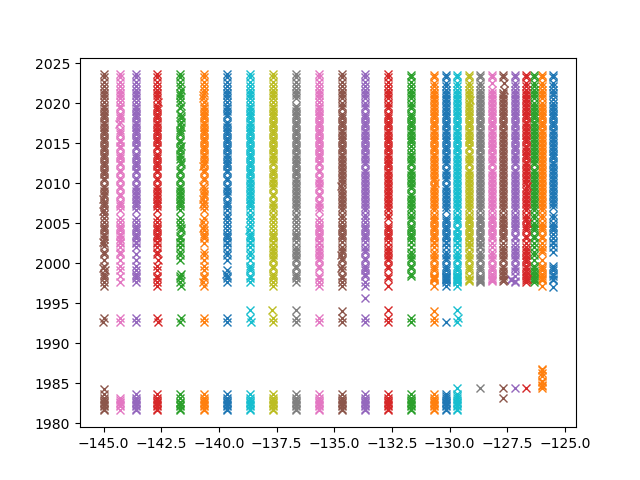

In [20]:
fig, ax = plt.subplots()
ax.plot(grid.longitude, grid.time, 'x')

In [14]:
grid.longitude[-1, :].diff(dim='station_ind')

<xarray.DataArray 'longitude' (station_ind: 26)>
array([-0.49783325,  0.        , -0.6676712 , -0.49966431, -0.4991684 ,
       -0.5008316 , -0.50067139, -0.49916077, -0.50083923, -0.49916077,
       -0.50067139, -0.99916077, -0.99966431, -1.00100708, -1.        ,
       -0.99949646, -1.00033569, -0.99949646, -1.00117493, -0.99899292,
       -0.99966431, -1.00067139, -1.00050354, -0.93766785, -1.39498901,
        0.69650269])
Coordinates:
    mission_ind  int64 107
  * station_ind  (station_ind) int64 1 2 3 4 5 6 7 8 ... 19 20 21 22 23 24 25 26

## OK try with all the LineP.  The above has big gaps because of names

In [14]:
names = glob.glob(f'LineP/*.nc')
names.sort()

station = xr.Dataset(coords={'depth':np.arange(0.5,5000.4), 'cast': np.arange(len(names))})
Nd = len(station.depth)
Nc = len(station.cast)
station['temperature'] = (('depth', 'cast'), np.zeros((Nd, Nc))*np.nan)

station['pressure'] = (('depth', 'cast'), np.zeros((Nd, Nc))*np.nan)
station['salinity'] = (('depth', 'cast'), np.zeros((Nd, Nc))*np.nan)
station['oxygen'] = (('depth', 'cast'), np.zeros((Nd, Nc))*np.nan)
station.oxygen.attrs['units'] = 'mL/L'

station['conductivity'] = (('depth', 'cast'), np.zeros((Nd, Nc))*np.nan)
station.conductivity.attrs['units'] = 'S/m'

station['time'] = (('cast'), np.zeros(Nc, dtype='datetime64[ns]'))
station['longitude'] = (('cast'), np.zeros(Nc))
station['latitude'] = (('cast'), np.zeros(Nc))
station['mission_id'] = (('cast'), Nc * ['              '])
station['project'] = (('cast'), Nc * ['              '])
station['instrument_model'] = (('cast'), Nc * ['              '])
station['instrument_serial_number'] = (('cast'), Nc * ['              '])
station['filename'] = (('cast'), Nc * ['              '])

for nn, name in enumerate(names):
    print(name)
    with xr.open_dataset(name) as ds:
        for td in ['latitude', 'longitude', 'time', 'project', 'mission_id', 'instrument_model', 'instrument_serial_number', 'filename']:
            if td in ds:
                station[td][nn] = ds[td]
        keys = ''
        for key in ds.keys():
            keys += ' ' + key
        # print(keys)
        if 'sea_water_temperature' in ds:
            station['temperature'][:, nn] = np.interp(station.depth, ds.depth, ds['sea_water_temperature'], 
                                                      right=np.nan, left=np.nan)
        else:
            for k in ds.keys():
                if 'TEMP' in k:
                    station['temperature'][:, nn] = np.interp(station.depth, ds.depth, ds[k], 
                                                      right=np.nan, left=np.nan)
            
        if 'sea_water_practical_salinity' in ds:
            station['salinity'][:, nn] = np.interp(station.depth, ds.depth, ds['sea_water_practical_salinity'], 
                                                      right=np.nan, left=np.nan)
        else:
            for k in ds.keys():
                if 'SALT' in k:
                    station['salinity'][:, nn] = np.interp(station.depth, ds.depth, ds[k], 
                                                      right=np.nan, left=np.nan)

        if 'DOXYZZ01' in ds:
            station['oxygen'][:, nn] = np.interp(station.depth, ds.depth, ds['DOXYZZ01'], 
                                                      right=np.nan, left=np.nan)
        if 'CNDST01' in ds:
            station['conductivity'][:, nn] = np.interp(station.depth, ds.depth, ds['CNDST01'], 
                                                      right=np.nan, left=np.nan)
        
        if 'CNDST01' in ds:
            station['conductivity'][:, nn] = np.interp(station.depth, ds.depth, ds['CNDST01'], 
                                                      right=np.nan, left=np.nan)
        if 'sea_water_pressure' in ds:
            station['pressure'][:, nn] = np.interp(station.depth, ds.depth, ds['sea_water_pressure'], 
                                                      right=np.nan, left=np.nan)
            
# now trim
#station = station.where(np.abs((station.longitude-station.longitude.median()) < 0.25) & 
#                        (np.abs(station.latitude-station.latitude.median()) < 0.25), drop=True)

station.to_netcdf(f'AllCastsLineP.nc')

LineP/1968-005-0014.ctd.nc
LineP/1968-005-0016.ctd.nc
LineP/1968-005-0017.ctd.nc
LineP/1968-005-0020.ctd.nc
LineP/1968-005-0021.ctd.nc
LineP/1968-005-0023.ctd.nc
LineP/1968-005-0026.ctd.nc
LineP/1968-009-0002.ctd.nc
LineP/1968-009-0003.ctd.nc
LineP/1968-009-0005.ctd.nc
LineP/1968-009-0006.ctd.nc
LineP/1968-009-0007.ctd.nc
LineP/1968-009-0008.ctd.nc
LineP/1968-009-0009.ctd.nc
LineP/1968-009-0010.ctd.nc
LineP/1968-009-0011.ctd.nc
LineP/1968-009-0012.ctd.nc
LineP/1968-009-0014.ctd.nc
LineP/1968-009-0016.ctd.nc
LineP/1968-009-0024.ctd.nc
LineP/1968-009-0028.ctd.nc
LineP/1968-009-0030.ctd.nc
LineP/1968-009-0031.ctd.nc
LineP/1968-011-0004.ctd.nc
LineP/1968-011-0006.ctd.nc
LineP/1969-001-0001.ctd.nc
LineP/1969-002-0002.ctd.nc
LineP/1969-002-0003.ctd.nc
LineP/1969-002-0004.ctd.nc
LineP/1969-002-0005.ctd.nc
LineP/1969-002-0006.ctd.nc
LineP/1969-002-0007.ctd.nc
LineP/1969-002-0008.ctd.nc
LineP/1969-002-0009.ctd.nc
LineP/1969-002-0010.ctd.nc
LineP/1969-002-0011.ctd.nc
LineP/1969-002-0012.ctd.nc
L

ValueError: shape mismatch: value array of shape (48786,) could not be broadcast to indexing result with 0 dimensions

<xarray.Dataset>
Dimensions:                   (depth: 5000, cast: 10040)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * cast                      (cast) int64 0 1 2 3 4 ... 10036 10037 10038 10039
Data variables: (12/13)
    temperature               (depth, cast) float64 7.65 9.035 8.248 ... nan nan
    pressure                  (depth, cast) float64 nan nan nan ... nan nan nan
    salinity                  (depth, cast) float64 32.5 32.52 32.52 ... nan nan
    oxygen                    (depth, cast) float64 nan nan nan ... nan nan nan
    conductivity              (depth, cast) float64 nan nan nan ... nan nan nan
    time                      (cast) datetime64[ns] 1968-05-24T18:48:00 ... 1...
    ...                        ...
    latitude                  (cast) float64 49.98 50.03 50.02 ... 0.0 0.0 0.0
    mission_id                (cast) <U14 '1968-005' ... '              '
    project                   (cast) <U14 'Station P' ... '              '
    instrument_model          (cast) <U14 '9006' '9006' ... '              '
    instrument_serial_number  (cast) <U14 '              ' ... '              '
    filename                  (cast) <U14 '1968-005-0014.' ... '              '

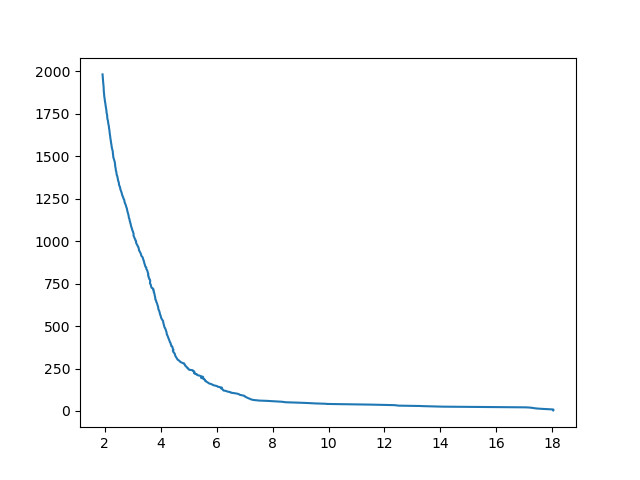

In [61]:
display(station)
fig, ax = plt.subplots()
ax.plot(station.temperature[:, -20], station.depth)

In [15]:
station.to_netcdf(f'AllCastsLineP.nc')

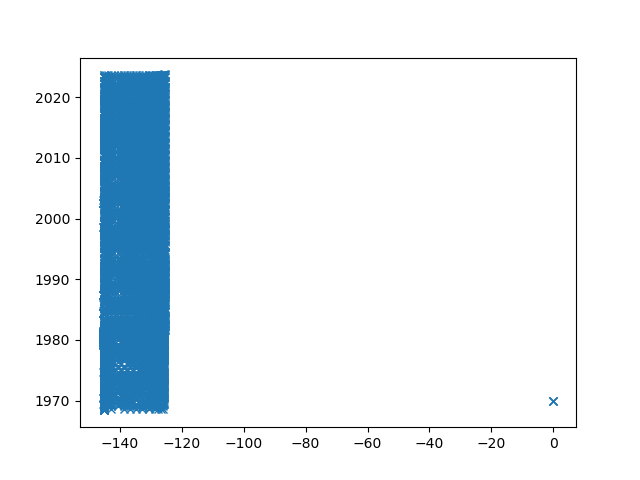

In [16]:
fig, ax = plt.subplots()
ax.plot(station.longitude, station.time, 'x')

## Get lat/lon of stations

In [3]:
dtypes = [('Stations', 'S5'), ('Lat', '<f8'), ('Latmin', '<f8'), ('Lon', '<f8'), ('Lonmin', '<f8'), ('depth', '<f8'), ('activity', 'S20')]
stationinfo = np.genfromtxt('./LinePStations.txt', dtype=dtypes, delimiter=' ', names=True, )

In [4]:
N = len(stationinfo)-3
station_info = xr.Dataset(coords={'stationind': np.arange(N)})
station_info['id'] = (('stationind'), ['     '] * N)
station_info['lon'] = (('stationind'), np.nan * np.zeros(N))
station_info['lat'] = (('stationind'), np.nan * np.zeros(N))
station_info['depth'] = (('stationind'), np.nan * np.zeros(N))
station_info['alongx'] = (('stationind'),  np.zeros(N))
for nn in range(N):
    station_info['id'][nn] = stationinfo[nn][0]
    station_info['lon'][nn] = - stationinfo[nn][3] - stationinfo[nn][4] / 60. 
    station_info['lat'][nn] = stationinfo[nn][1] + stationinfo[nn][2] / 60. 
    station_info['depth'][nn] = stationinfo[nn][5]
    
# lets defeine an alongline x...
dist, head = seawater.dist(station_info.lat, station_info.lon)
print(dist)
station_info['alongx'][1:] = np.cumsum(dist)
station_info['alongx'] = -(station_info['alongx'] - station_info['alongx'][0])
station_info.to_netcdf('LinePStations.nc')

[36.8564217  24.64599247 24.63394203 36.9819102  37.10381091 36.81277945
 36.86813035 36.83915119 36.76847767 36.78355931 36.71278897 73.34559807
 73.32012692 73.16205223 73.1354992  72.81448377 72.91667488 72.59478007
 72.49697809 72.39908037 72.30108707 72.20299832 72.14135523 69.54574299
 49.77240733 49.86764274]


In [33]:
display(station_info)

<xarray.Dataset>
Dimensions:     (stationind: 27)
Coordinates:
  * stationind  (stationind) int64 0 1 2 3 4 5 6 7 8 ... 19 20 21 22 23 24 25 26
Data variables:
    id          (stationind) <U5 'P1' 'P2' 'P3' 'P4' ... 'P24' 'P25' 'P35' 'P26'
    lon         (stationind) float64 -125.5 -126.0 -126.3 ... -144.3 -145.0
    lat         (stationind) float64 48.58 48.6 48.62 48.65 ... 50.0 50.0 50.0
    depth       (stationind) float64 120.0 114.0 750.0 ... 4e+03 4.3e+03
    alongx      (stationind) float64 -0.0 -36.86 -61.5 ... -1.373e+03 -1.423e+03

## Get all mission ids:

In [9]:
missions = []
with xr.open_dataset('AllCastsLineP.nc') as ds:
    for mi in ds.mission_id.values:
        if not mi in missions:
            missions += [mi]
print(missions)

['1968-005', '1968-009', '1968-011', '1969-001', '1969-002', '1969-004', '1969-005', '1969-006', '1969-007', '1969-008', '1969-009', '1970-001', '1970-002', '1970-003', '1970-004', '1970-005', '1970-006', '1970-007', '1970-009', '1971-001', '1971-002', '1971-003', '1971-004', '1971-005', '1971-006', '1971-008', '1972-001', '1972-002', '1972-003', '1972-004', '1972-005', '1972-006', '1972-007', '1972-009', '1972-010', '1973-001', '1973-003', '1973-004', '1973-006', '1973-007', '1973-008', '1973-009', '1974-001', '1974-002', '1974-005', '1974-006', '1974-007', '1974-008', '1974-009', '1975-001', '1975-002', '1975-004', '1975-005', '1975-007', '1975-009', '1975-010', '1976-001', '1976-002', '1976-004', '1976-005', '1976-006', '1976-007', '1976-008', '1976-009', '1977-001', '1977-002', '1977-003', '1977-004', '1977-005', '1977-006', '1977-007', '1977-008', '1977-009', '1978-001', '1978-002', '1978-003', '1978-004', '1978-005', '1978-006', '1978-007', '1978-008', '1978-009', '1979-002', '19

In [48]:
with xr.open_dataset('AllCastsLineP.nc') as ds:
    Nmission = len(missions)
    Nstations = 27
    grid = xr.Dataset(coords={'depth': ds.depth.values, 'mission_ind': np.arange(Nmission), 'station_ind': np.arange(Nstations)})
    for k in ds.keys():
        if ds[k].ndim == 2:
            grid[k] = (('depth', 'mission_ind', 'station_ind'), np.nan * np.zeros((len(ds.depth), Nmission, 27)))
        elif ds[k].ndim == 1:
            if ds[k].dtype == 'float64':
                grid[k] = (('mission_ind', 'station_ind'), np.nan * np.zeros((Nmission, 27)))
            elif ds[k].dtype == 'object':
                grid[k] = (('mission_ind', 'station_ind'),  [['            '] * 27] * Nmission)
            else:
                grid[k] = (('mission_ind', 'station_ind'), np.zeros( (Nmission, 27), dtype='datetime64[ns]'))

    for castn in range(len(ds.cast)):
        if castn % 100 == 0:
            print(castn)
        cast = ds.isel(cast=castn)
        dx = np.sqrt((np.cos(50*np.pi/180)*(cast.longitude - station_info.lon))**2 +  (cast.latitude - station_info.lat)**2)
        if np.min(dx) > 0.12:
            station_ind = dx.argmin()

            #print(dx.min().values, f'too big, not at a station closest {station_info.id[station_ind].values}')
            continue
        station_ind = dx.argmin()
        #print(dx.min().values, f'from {station_info.id[station_ind].values}')
        # figure out mission index:
        nmission = missions.index(cast.mission_id.values)
        # print('Mission:',  nmission)
        ngoodalready = np.isfinite(grid['temperature'][:, nmission, station_ind]).sum(axis=0)
        ngoodprofile = np.isfinite(cast['temperature']).sum(axis=0)
        if ngoodprofile > ngoodalready:
            for k in cast.keys():
                if cast[k].ndim == 1:
                    grid[k][:, nmission, station_ind] = cast[k]
                else:
                    grid[k][nmission, station_ind] = cast[k]


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [50]:
grid.to_netcdf('InitialGrid.nc')

Some of the missions in this initial grid are pretty empty, and probably not adequte for what we are planning to do here...

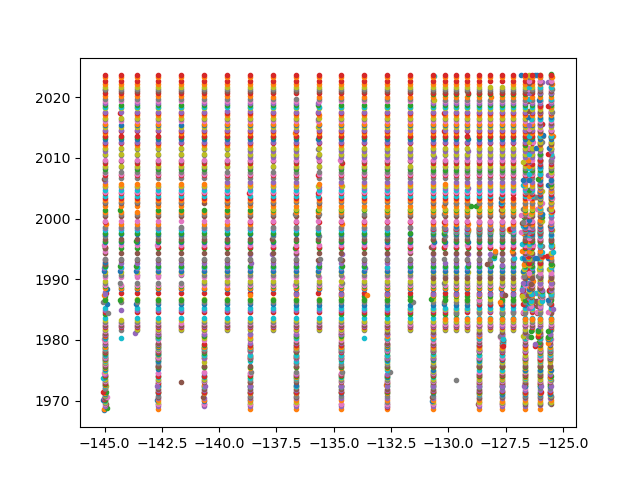

In [51]:
fig, ax = plt.subplots()
ax.plot(grid.longitude.T, grid.time.T, '.');

In [52]:
with xr.open_dataset('InitialGrid.nc') as grid:
    grid['maxdepth'] = np.isfinite(grid.temperature).sum(dim='depth')
    grid.maxdepth.attrs = {'units': 'm', 'description':'maximum depth of data in profile'}
    grid['station_id'] = (('station_ind'), station_info.id.data)
    grid['station_alongx'] = (('station_ind'), station_info.alongx.data)
    grid.station_alongx.attrs = {'units':'km along LineP; P1=0, P26=-1423', 'description': 'nominal station location'}
    grid['alongx'] = (('mission_ind', 'station_ind'), np.interp(grid.longitude, station_info.lon, station_info.alongx))
    grid.alongx.attrs = {'units':'km along LineP; P1=0, P26=-1423', 'description': 'station location interpolated by longitude'}
    
    display(grid)
    grid.to_netcdf('InitialGridNew.nc')

<xarray.Dataset>
Dimensions:                   (depth: 5000, mission_ind: 515, station_ind: 27)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * mission_ind               (mission_ind) int64 0 1 2 3 4 ... 511 512 513 514
  * station_ind               (station_ind) int64 0 1 2 3 4 5 ... 22 23 24 25 26
Data variables: (12/17)
    temperature               (depth, mission_ind, station_ind) float64 nan ....
    pressure                  (depth, mission_ind, station_ind) float64 ...
    salinity                  (depth, mission_ind, station_ind) float64 ...
    oxygen                    (depth, mission_ind, station_ind) float64 ...
    conductivity              (depth, mission_ind, station_ind) float64 ...
    time                      (mission_ind, station_ind) datetime64[ns] ...
    ...                        ...
    instrument_serial_number  (mission_ind, station_ind) object ...
    filename                  (mission_ind, station_ind) object ...
    maxdepth                  (mission_ind, station_ind) int64 0 0 0 0 ... 0 0 0
    station_id                (station_ind) <U5 'P1' 'P2' 'P3' ... 'P35' 'P26'
    station_alongx            (station_ind) float64 -0.0 -36.86 ... -1.423e+03
    alongx                    (mission_ind, station_ind) float64 nan nan ... nan

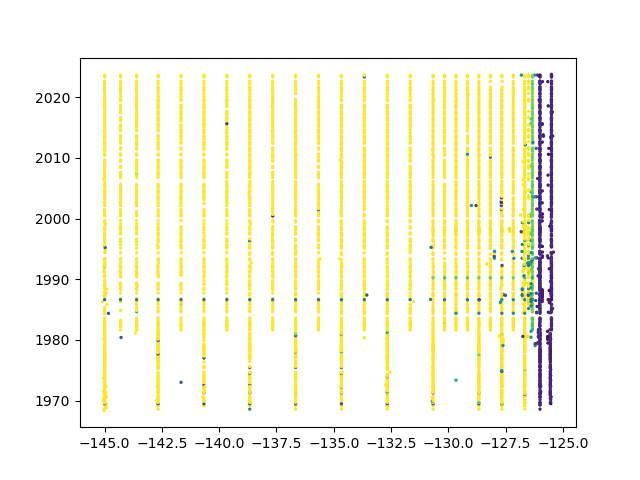

In [53]:
fig, ax  = plt.subplots()
ax.scatter(grid.longitude, grid.time, c=grid.maxdepth, vmin=0, vmax=1000, s=2)

In [112]:
for ind in range(len(grid.station_ind)):
    grid['time'][:, ind][~np.isfinite(grid.latitude[:, ind])] = np.datetime64('nat', 'ns')
mission_ind = np.where(grid.time[:, -1]>=np.datetime64('1986-08-01'))[0][0]
print(mission_ind)
print(grid.longitude[148, -1])
print(grid.time[148, -1])
print(grid.time[145:155, :].mean(dim='station_ind'))
print(grid.mission_id[147, -1].values)
print(grid.mission_id[152, -1].values)

148
<xarray.DataArray 'longitude' ()>
array(-145.)
Coordinates:
    mission_ind  int64 148
    station_ind  int64 26
<xarray.DataArray 'time' ()>
array('1986-10-22T21:24:00.000000000', dtype='datetime64[ns]')
Coordinates:
    mission_ind  int64 148
    station_ind  int64 26
<xarray.DataArray 'time' (mission_ind: 10)>
array(['1985-07-10T07:25:42.000000000', '1985-08-13T10:42:00.000000000',
       '1986-04-18T19:18:26.666666668', '1986-10-18T07:44:00.000000000',
       '1986-02-06T13:06:00.000000000', '1986-04-20T19:45:00.000000000',
       '1986-07-17T02:18:00.000000000', '1986-08-22T21:26:24.000000000',
       '1986-09-10T13:36:00.000000000', '1986-11-09T15:45:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * mission_ind  (mission_ind) int64 145 146 147 148 149 150 151 152 153 154
1986-001
1986-014


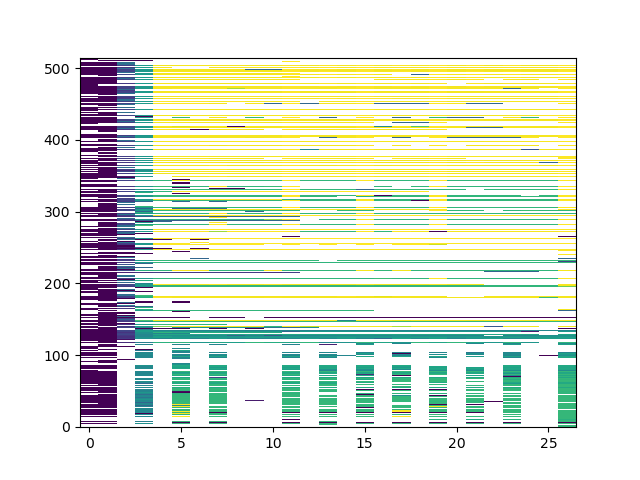

In [88]:
fig, ax = plt.subplots()

ax.pcolormesh(grid.station_ind, grid.mission_ind, grid.maxdepth + 0 * grid.longitude, vmin=500, vmax=2000)

In [4]:
with xr.open_dataset('InitialGridNew.nc') as ds:
    display(ds)

<xarray.Dataset>
Dimensions:                   (depth: 5000, mission_ind: 515, station_ind: 27)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * mission_ind               (mission_ind) int64 0 1 2 3 4 ... 511 512 513 514
  * station_ind               (station_ind) int64 0 1 2 3 4 5 ... 22 23 24 25 26
Data variables: (12/17)
    temperature               (depth, mission_ind, station_ind) float64 ...
    pressure                  (depth, mission_ind, station_ind) float64 ...
    salinity                  (depth, mission_ind, station_ind) float64 ...
    oxygen                    (depth, mission_ind, station_ind) float64 ...
    conductivity              (depth, mission_ind, station_ind) float64 ...
    time                      (mission_ind, station_ind) datetime64[ns] ...
    ...                        ...
    instrument_serial_number  (mission_ind, station_ind) object ...
    filename                  (mission_ind, station_ind) object ...
    maxdepth                  (mission_ind, station_ind) int64 ...
    station_id                (station_ind) object ...
    station_alongx            (station_ind) float64 ...
    alongx                    (mission_ind, station_ind) float64 ...

In [30]:
ds.depth.values

array([   0.,    5.,   10.,   15.,   20.,   30.,   35.,   40.,   50.,
         60.,   70.,   75.,   80.,   90.,  100.,  110.,  115.,  120.,
        130.,  140.,  150.,  160.,  170.,  180.,  200.,  210.,  230.,
        250.,  275.,  300.,  330.,  350.,  375.,  400.,  450.,  500.,
        550.,  600.,  655.,  700.,  750.,  800.,  860.,  900.,  950.,
       1000., 1050., 1100., 1160., 1200.], dtype=float32)

Something weird about mission_ind = 152

In [142]:
station_info

<xarray.Dataset>
Dimensions:     (stationind: 27)
Coordinates:
  * stationind  (stationind) int64 0 1 2 3 4 5 6 7 8 ... 19 20 21 22 23 24 25 26
Data variables:
    id          (stationind) <U5 'P1' 'P2' 'P3' 'P4' ... 'P24' 'P25' 'P35' 'P26'
    lon         (stationind) float64 -125.5 -126.0 -126.3 ... -144.3 -145.0
    lat         (stationind) float64 48.58 48.6 48.62 48.65 ... 50.0 50.0 50.0
    depth       float64 4.3e+03

In [31]:
with xr.open_dataset('InitialGridNew.nc') as grid:
        
    # Get some mission stats
    grid['ncasts'] = (('mission_ind'), np.zeros(len(grid.mission_ind)))
    grid['furthest'] = (('mission_ind'), np.zeros(len(grid.mission_ind)))
    grid['mission'] = (('mission_ind'), len(grid.mission_ind) * ['            '])
    grid['mission_time'] = (('mission_ind'), np.zeros(len(grid.mission_ind), dtype='datetime64[ns]'))
    grid['station_name'] = (('station_ind'), len(grid.station_ind) * ['   '])
    for ind in grid.station_ind:
        grid['station_name'][ind] = station_info.id[ind]
    
    for ind in grid.mission_ind:
        good = np.where(grid.maxdepth[ind, :]>500)[0]
        grid['ncasts'][ind] = len(good)
        if len(good) > 0:
            grid['furthest'][ind] = max(good)
    
        goodt = np.where(grid.time[ind, :] != np.datetime64('1970-01-01T00:00:00'))[0]
        if len(goodt):
            grid['mission_time'][ind] = grid.time[ind, :][goodt].mean()
    
        # trim to just one d
        if True:
            for nn in grid.station_ind:
                if len(str(grid['mission_id'][ind, nn].values).strip())>0:
                    # print(str(grid['mission_id'][ind, nn].values))
                    grid['mission'][ind] = str(grid['mission_id'][ind, nn].values).strip()
                    continue
    display(grid)
    grid.to_netcdf('_LinePGrid.nc')

<xarray.Dataset>
Dimensions:                   (depth: 5000, mission_ind: 515, station_ind: 27)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * mission_ind               (mission_ind) int64 0 1 2 3 4 ... 511 512 513 514
  * station_ind               (station_ind) int64 0 1 2 3 4 5 ... 22 23 24 25 26
Data variables: (12/22)
    temperature               (depth, mission_ind, station_ind) float64 ...
    pressure                  (depth, mission_ind, station_ind) float64 ...
    salinity                  (depth, mission_ind, station_ind) float64 ...
    oxygen                    (depth, mission_ind, station_ind) float64 ...
    conductivity              (depth, mission_ind, station_ind) float64 ...
    time                      (mission_ind, station_ind) datetime64[ns] ...
    ...                        ...
    alongx                    (mission_ind, station_ind) float64 ...
    ncasts                    (mission_ind) float64 1.0 9.0 1.0 ... 0.0 25.0 0.0
    furthest                  (mission_ind) float64 26.0 26.0 26.0 ... 26.0 0.0
    mission                   (mission_ind) <U12 '1968-005' ... '            '
    mission_time              (mission_ind) datetime64[ns] 1968-05-24T18:48:0...
    station_name              (station_ind) <U3 'P1' 'P2' 'P3' ... 'P35' 'P26'

In [30]:
goodt

array([], dtype=int64)

In [39]:
grid.mission.dtype

dtype('O')

In [15]:
with xr.open_dataset('_LinePGrid.nc') as grid0:
    good = np.where((grid0.ncasts>4) & (grid0.furthest>9))[0]
    grid = grid0.isel(mission_ind=good)
    grid['mission'] = grid.mission.astype('S8')
    grid['potential_density'] = (('depth', 'mission_ind', 'station_ind'), 
                                 seawater.pden(grid.salinity, grid.temperature, grid.pressure, 0))
    grid.potential_density.attrs = {'units':'kg m^-3', 'description':'potential density relative to 0 dbar'} 
    grid['potential_temperature'] = (('depth', 'mission_ind', 'station_ind'), 
                                     seawater.ptmp(grid.salinity, grid.temperature, grid.pressure, 0))
    grid.potential_temperature.attrs = {'units':'C', 'description':'potential temperature relative to 0 dbar'} 
    grid.time.encoding = {'units': 'days since 1900-01-01', 'dtype':'float64', 'calendar':'proleptic_gregorian'}
    grid.mission_time.encoding = {'units': 'days since 1900-01-01', 'dtype':'float64', 'calendar':'proleptic_gregorian'}

    grid.attrs = {'Conventions': 'CF-1.11',
                  'title': 'Line P cruise grid',
                  'institution': 'Institute of Ocean Sciences, Sidney, BC, Canada',
                  'creator': 'Jody Klymak',
                  'creator_institution': 'University of Victoria, BC, Canada',
                  'email': 'jklymak@uvic.ca',
                  'source': 'Ship CTD data, collected since 1968 along LineP by IOS',
                  'history': 'CTD data from waterproperties.ca, defined area "LineP".  Binned by ProcessStations.ipynb',
                  'comment': 'All casts in "LineP" area were downloaded from waterproperties.ca. '
                             'Profile data was approximately 1-m, but not exactly (for some reason), so '
                              'depth was interpolated to exactly 1-m (leading to a bit of interpolation '
                              'smoothing).  Using the nominal stations locations, casts were assigned to '
                              'a station if they were within 0.12 degrees latitude of the station.  For each '
                              'mission, the deepest profile at each station was retained.  A mission was '
                              'retained if it has at least 4 casts, and the furthest cast was at least  '
                              'as far out as P10.',
                  'references': 'https://github.com/jklymak/LinePGrid/',
                  'keywords': 'CTD, Oceans, Ocean Pressure, '
                              'Water Pressure, Oceans, Ocean Temperature, Water Temperature, '
                              'Oceans, Salinity/Density, Conductivity, Oceans, '
                              'Salinity/Density, Density, Oceans, Salinity/Density, Salinity',
                  'keywords_vocabulary': 'GCMD Science Keywords',
                  'license': 'This data may be redistributed and used without restriction or warranty',
                  'sea_name': 'Coastal Waters of Southeast Alaska and British Columbia',
                  'standard_name_vocabulary': 'CF STandard Name Table v85'
                 }
    grid.depth.attrs = {
        'standard_name': 'depth',
        'long_name': 'depth of CTD [m]',
        'units': 'm',
        'positive': 'down',
        'comment': 'Data was interpolated onto 1-m grid from data that '
                   'was almost on a 1-m grid.  There will be some smoothing.'
    }
    grid.mission_ind.attrs = {
        'long_name': 'mission index',
        'comment': 'index into the mission list' 
    }
    grid.station_ind.attrs = {
        'long_name': 'mission index',
        'comment': 'index in the station list.  Note that P1 is 0, P25 is 24 '
                   'P35 is 25 and P26 is 26.'
    }
    grid.temperature.attrs = {
        'standard_name': 'sea_water_temperature',
        'units': 'Celsius', 
        'long_name': 'Temperature [C]',
        'comment': 'From various CTDs so variable accuracy'
    }
    grid.pressure.attrs = {
        'standard_name': 'sea_water_pressure',
        'units': 'dbar',
        'long_name': 'Pressure [dbar]'
    }
    grid.salinity.attrs = {
        'standard_name': 'sea_water_practical_salinity',
        'units': 'psu',
        'long_name': 'Salinity [psu]',
        'comment': 'From various CTDs, probably from EOS80'
    }
    grid.oxygen.attrs = {
        'standard_name': 'mole_concentration_of_dissolved_molecular_oxygen_in_sea_water',
        'units': 'umol l-1',
        'long_name': 'O2 concentration [umol l^-1]',
        'comment': 'Many older CTDs did not have O2'
    }
    grid.conductivity.attrs = {
        'standard_name': 'sea_water_electrical_conductivity',
        'units': 'S m-1',
        'long_name': 'Conductivity [S m^-1]',
        'comment': 'Conductivty not reported for older CTDs'
    }
    grid.potential_density.attrs = {
        'standard_name': 'sea_water_potential_density',
        'long_name': 'potential density [kg m-3]',
        'comment': 'potential density relative to 0 dbar, using EOS80',
        'units': 'kg m-3'}
    
    grid.potential_temperature.attrs = {
        'standard_name': 'sea_water_potential_temperature',
        'long_name': 'potential temperature [C]',
        'units': 'Celsius',
        'comment': 'potential temperature relative to 0 dbar, using EOS80'}
    
    grid.time.attrs['standard_name'] = 'time'
    grid.time.attrs['long_name'] = 'CTD cast time'
    grid.mission_time.attrs['standard_name'] = 'time'
    grid.mission_time.attrs['long_name'] = 'Average mission time'

    grid.maxdepth.attrs['long_name'] = 'Maximum Cast depth'
    grid.maxdepth.attrs['positive'] = 'down'
    grid.maxdepth.attrs['comment'] = 'Maximum cast depth for this station for this mission'

    grid.alongx.attrs['long_name'] = 'distance along line P [km]'
    grid.alongx.attrs['units'] = 'km'
    grid.alongx.attrs['comment'] = ('km along LineP; P1=0, P26=-1423; negative '
                             'because lineP goes to the west')
    
    grid.station_alongx.attrs['long_name'] = 'distance along line P [km]'
    grid.station_alongx.attrs['units'] = 'km'
    grid.station_alongx.attrs['comment'] = ('Nominal station km along LineP; P1=0, P26=-1423; negative '
                             'because lineP goes to the west')

    grid.latitude.attrs = {'long_name': 'latitude [N]',
                           'standard_name': 'latitude',
                           'units':        'degrees_north'}
    
    grid.longitude.attrs = {'long_name': 'longitude [E]',
                           'standard_name': 'longitude',
                           'units':        'degrees_east',
                           'comment': 'west is less than zero'}

    grid.station_id.attrs = {'long_name': 'Station Name'}
    grid.mission.attrs = {'long_name': 'Mission Name',
                         'comment': 'IOS mission name. Note these '
                                    'are not necessarily in chronological '
                                    'order'}
    grid.mission.attrs = {'long_name': 'Mission Name',
                         'comment': 'IOS mission name. Note these '
                                    'are not necessarily in chronological '
                                    'order'}
    
    # get station lon and lat
    with xr.open_dataset('LinePStations.nc') as stations:
        grid['station_lon'] = ('station_ind', stations.lon.data)
        grid.station_lon.attrs = {'long_name': 'longitude [E]',
                           'standard_name': 'longitude',
                           'units':        'degrees_east',
                           'comment': 'Nominal station location. west is less than zero'}

        grid['station_lat'] = ('station_ind', stations.lat.data)
        grid.station_lat.attrs = {'long_name': 'latitude [N]',
                           'standard_name': 'latitude',
                           'units':        'degrees_north',
                           'comment': 'Nominal station location'}
    
    display(grid)

    grid.to_netcdf('LinePGrid.nc')

PermissionError: [Errno 13] Permission denied: b'/Users/jklymak/Dropbox/LinePTullyCruises/netcdfs/LinePGrid.nc'

In [16]:
grid.to_netcdf('LinePGrid.nc')

In [17]:
grid

<xarray.Dataset>
Dimensions:                   (depth: 5000, mission_ind: 204, station_ind: 27)
Coordinates:
  * depth                     (depth) float64 0.5 1.5 2.5 ... 4.998e+03 5e+03
  * mission_ind               (mission_ind) int64 1 4 5 7 8 ... 501 503 511 513
  * station_ind               (station_ind) int64 0 1 2 3 4 5 ... 22 23 24 25 26
Data variables: (12/24)
    temperature               (depth, mission_ind, station_ind) float64 nan ....
    pressure                  (depth, mission_ind, station_ind) float64 nan ....
    salinity                  (depth, mission_ind, station_ind) float64 nan ....
    oxygen                    (depth, mission_ind, station_ind) float64 ...
    conductivity              (depth, mission_ind, station_ind) float64 ...
    time                      (mission_ind, station_ind) datetime64[ns] ...
    ...                        ...
    furthest                  (mission_ind) float64 26.0 26.0 26.0 ... 26.0 26.0
    mission                   (mission_ind) |S8 b'1968-009' ... b'2023-088'
    mission_time              (mission_ind) datetime64[ns] ...
    station_name              (station_ind) object ...
    potential_density         (depth, mission_ind, station_ind) float64 nan ....
    potential_temperature     (depth, mission_ind, station_ind) float64 nan ....

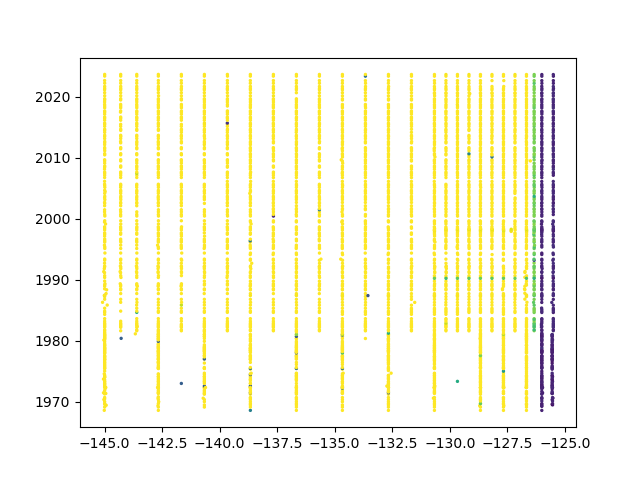

In [14]:
with xr.open_dataset('LinePGrid.nc') as grid:
    fig, ax  = plt.subplots()
    ax.scatter(grid.longitude, grid.time, c=grid.maxdepth, vmin=0, vmax=1000, s=2)

In [3]:
grid.mission.values

array([b'1968-009', b'1969-002', b'1969-004', b'1969-006', b'1969-007',
       b'1970-001', b'1970-004', b'1970-005', b'1970-007', b'1971-003',
       b'1971-004', b'1971-005', b'1971-006', b'1971-008', b'1972-002',
       b'1972-003', b'1972-004', b'1972-005', b'1972-006', b'1972-007',
       b'1972-009', b'1972-010', b'1973-001', b'1973-003', b'1973-004',
       b'1973-006', b'1973-007', b'1973-009', b'1974-001', b'1974-002',
       b'1974-005', b'1974-007', b'1974-008', b'1975-001', b'1975-004',
       b'1975-005', b'1975-007', b'1975-009', b'1975-010', b'1976-002',
       b'1976-004', b'1976-005', b'1976-006', b'1976-008', b'1976-009',
       b'1977-001', b'1977-003', b'1977-004', b'1977-005', b'1977-006',
       b'1977-009', b'1978-001', b'1978-002', b'1978-003', b'1978-004',
       b'1978-005', b'1978-006', b'1978-007', b'1978-008', b'1978-009',
       b'1979-002', b'1979-003', b'1979-004', b'1979-006', b'1979-008',
       b'1980-001', b'1980-002', b'1980-003', b'1980-004', b'198

## Add some other variables...

In [6]:
grid.station_alongx[-1].values

array(-1423.02347151)

AttributeError: 'Dataset' object has no attribute 'temperature'

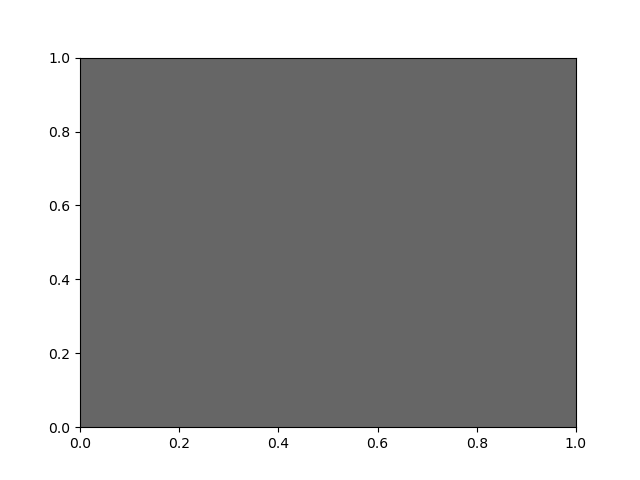

In [11]:
with xr.open_dataset('LinePGrid.nc') as grid:
    fig, ax = plt.subplots()
    ax.set_facecolor('0.4')
    ind = -1
    dT = grid.temperature[:, :, ind]-grid.temperature[:, :, ind].mean(dim=('mission_ind'))
    dT = dT / grid.temperature[:, :, ind].std(dim=('mission_ind'))
    ax.pcolormesh(grid.mission_time, grid.depth, dT, cmap='RdBu_r', vmin=-3, vmax=3)
    ax.contour(grid.mission_time, grid.depth, grid.potential_density[:, :, ind], levels=np.arange(1020, 1030, 0.5))
    ax.set_ylim([4000, 0])


In [6]:
inds = np.where((grid.mission_time >= np.datetime64('2000-01-01')) & (grid.mission_time <= np.datetime64('2010-01-01')))[0]
meanpden = grid.potential_density[:,inds].mean(dim=('mission_ind', 'station_ind'))

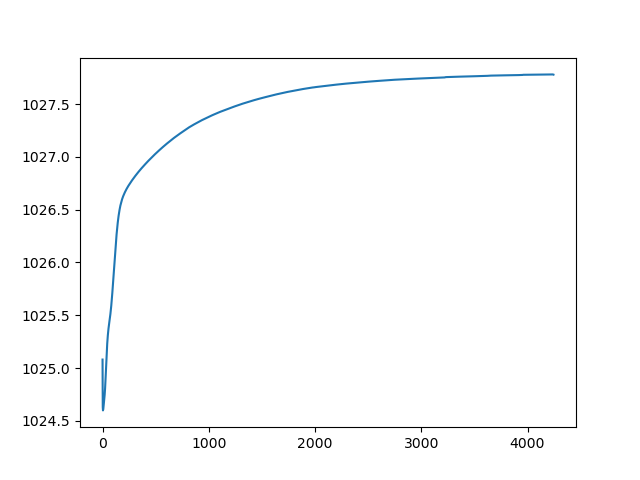

In [8]:
meanpden

<xarray.DataArray 'potential_density' (depth: 5000)>
array([1025.08087956, 1024.74208556, 1024.62992202, ...,           nan,
                 nan,           nan])
Coordinates:
  * depth    (depth) float64 0.5 1.5 2.5 3.5 ... 4.998e+03 4.998e+03 5e+03

In [10]:
with xr.open_dataset('LinePGrid.nc') as grid:
    
grid.to_netcdf('LinePGridNew.nc')

AttributeError: 'Dataset' object has no attribute 'salinity'